# Exploratory Data Analysis

Planning - Acquisition - Preparation - **Exploratory Analysis** - Modeling - Product Delivery

In this lesson, we introduce exploratory data analysis, called EDA, which is the "explore" stage in the DS Pipeline.

## Goals of EDA

We explore the interactions of the attributes and target variable to help discover drivers of our target variable and redundant or interdependent attributes. 

1. Discover features that are driving the outcome (target). (Number 1 reason to explore)
2. Learn the vast majority of our takeaways and interesting stories from the data. 
3. Discover if we need to drop features, if we need to handle missing values, or if there's value to combining features. 

## EDA Process

1. Hypothesize: Form and document your initial hypotheses about how the predictors (independent variables, features, or attributes) interact with the target (y-value or dependent variable). You can do this in the form of questions in a natural language (as opposed to "statistical" language). 

2. Visualize: use visualization techniques to identify drivers. When a visualization needs to be followed up with a statistical test, do so.

3. Test your hypotheses when visualization isn't immediately clear. Use the appropriate statistical tests (t-tests, correlation, chi-square)

**General Recipe**

1. Univariate Stats: descriptive stats, frequencies, histograms. This is often done during prep prior to splitting into train/validate/test, but if it is not, then it should be done first here. Why? Outliers. Running tests that assume normalcy. Scale of each variable. General "getting to know" your data. 

    - Univariate means a single variable, so we'll look at `.value_counts()` and histograms.
    - Explore the target variable itself. What is the distribution of values?  
    - Explore the categorical and qualitative variables. 
    - Explore the numeric variables. 


2. Bivariate Stats. Bivariate means two variables.

    - Plot the interactions of each variable with the target. Document your takeaways.     
    - Explore interation of independent variables using viz and/or hypothesis testing to address interdependence. 


3. Multivariate Stats (more than 2 variables): Ask additional questions of the data, such as how subgroups compare to each-other and to the overall population. Answer questions using visualizations and/or hypothesis testing. 

    - use color to represent a discrete variable and then choose a chart style based on the data types of other two variables. 

4. Statistical Tests: If the visualizations are not crystal clear, it's important to conduct hypothesis tests.

    - With numeric to numeric, test for correlation with Pearson's R for linear and Spearman's R for non-linear relationships.

    - For numeric to categorical, compare the means of two populations or a subgroup to the population using a [t-test](https://ds.codeup.com/stats/compare-means/), if your samples are normaly(ish) distributed but have different variances (as determined by calling `.var()` on each column/Series, [ANOVA](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html) to compare means from more than 2 groups, or a [Mann-Whitney u-test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html) if the data does not match the [assumptions of a t-test](https://www.investopedia.com/ask/answers/073115/what-assumptions-are-made-when-conducting-ttest.asp).

    - With categorical to categorical variables, use $\chi^2$, [chi-squared test](https://ds.codeup.com/stats/compare-group-membership/).


**Standing Orders** for Exploration

- **Document** your initial questions or assumptions. Write them down (in your README or notebook) so they are concrete and not in your head.

- **Document** your takeaways after each visualization. Even if your takeaway is, "there is nothing interesting between *var1* and *target*". 

- **Document** your answer to each question. 

- When you run statistical tests to answer your questions, **Document** your null and alternative hypothesis, the test you run, the test results, and your conclusion. 

- **Document** your takeaways, in case that wasn't clear. It is a huge component of your final deliverable/analysis.

- **Document** your action plan.  What are your next steps and/or new questions based on what you have learned? I recommend documenting, continuing through all of your questions, and then going back and taking action only after you have answered your initial questions. 

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split

np.random.seed(123)

## Aquire

Acquire Titanic data from our mySQL database

In [2]:
import env

def get_connection(db, user=env.user, host=env.host, password=env.password):
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

def get_titanic():
    my_query="SELECT * FROM passengers"
    df = pd.read_sql(my_query, get_connection('titanic_db'))
    return df

In [3]:
df = get_titanic()
df.head(2)

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone
0,0,0,3,male,22.0,1,0,7.2500,S,Third,None,Southampton,0
1,1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,0


In [4]:
df.isna().sum()

passenger_id      0
survived          0
pclass            0
sex               0
age             177
sibsp             0
parch             0
fare              0
embarked          2
class             0
deck            688
embark_town       2
alone             0
dtype: int64

In [5]:
# Useful helper for checking for nulls
# What proportion of each column is empty?
df.isna().mean()

passenger_id    0.000000
survived        0.000000
pclass          0.000000
sex             0.000000
age             0.198653
sibsp           0.000000
parch           0.000000
fare            0.000000
embarked        0.002245
class           0.000000
deck            0.772166
embark_town     0.002245
alone           0.000000
dtype: float64

## Prepare

Prepare the Titanic data. We apply the same steps before splitting so that we handle edge cases identically.

- drop deck since most of the data is missing
- drop rows where age or embarked is missing
- drop passenger_id, since it adds no new information
- drop class, as encoded values are in pclass
- create dummy vars & drop sex, embark_town

**Questions for 2nd draft** 

- Let's investigate and determine what are best options are for handling the missing ages

In [6]:
# drop rows where age or embarked is null, drop column 'deck', drop passenger_id
def prep_titanic(df):
    '''
    take in titanc dataframe, remove all rows where age or embarked is null, 
    get dummy variables for sex and embark_town, 
    and drop sex, deck, passenger_id, class, and embark_town. 
    '''

    df = df[(df.age.notna()) & (df.embarked.notna())]
    df = df.drop(columns=['deck', 'passenger_id', 'class'])

    dummy_df = pd.get_dummies(df[['sex', 'embark_town']], prefix=['sex', 'embark'])

    df = pd.concat([df, dummy_df.drop(columns=['sex_male'])], axis=1)

    df = df.drop(columns=['sex', 'embark_town']) 
    
    df = df.rename(columns={"sex_female": "is_female"})

    return df

In [7]:
df = prep_titanic(df)
df.head(2)

,survived,pclass,age,sibsp,parch,fare,embarked,alone,is_female,embark_Cherbourg,embark_Queenstown,embark_Southampton
0,0,3,22.0,1,0,7.2500,S,0,0,0,0,1
1,1,1,38.0,1,0,71.2833,C,0,1,1,0,0


**Split** data into Train, Validate, Test

In [8]:
def train_validate_test_split(df, target, seed=123):
    '''
    This function takes in a dataframe, the name of the target variable
    (for stratification purposes), and an integer for a setting a seed
    and splits the data into train, validate and test. 
    Test is 20% of the original dataset, validate is .30*.80= 24% of the 
    original dataset, and train is .70*.80= 56% of the original dataset. 
    The function returns, in this order, train, validate and test dataframes. 
    '''
    train_validate, test = train_test_split(df, test_size=0.2, 
                                            random_state=seed, 
                                            stratify=df[target])
    train, validate = train_test_split(train_validate, test_size=0.3, 
                                       random_state=seed,
                                       stratify=train_validate[target])
    return train, validate, test

In [9]:
# Stratify with categorical target variables
train, validate, test = train_validate_test_split(df, target='survived')
train.shape, validate.shape, test.shape

((398, 12), (171, 12), (143, 12))

In [10]:
# Stratification means we'll get even proportions of the target variable in each data set
train.survived.mean(), validate.survived.mean(), test.survived.mean()

(0.4045226130653266, 0.40350877192982454, 0.40559440559440557)

## Explore Individual Variables 

For Univariate exploration, a good first step is to run `.value_counts`, calculate proportions, or visualize a histogram of the target.

This way we're looking at univariate information, distributions, and descriptive statistics.

Descriptive stats, frequencies, histograms help tell us a lot about a single variable.

This is often done during prep prior to splitting into train/validate/test, but if it is not, then it should be done first here. Why? Outliers. Running tests that assume normalcy. Get a sense of scale for each variable. General "getting to know" your data.  

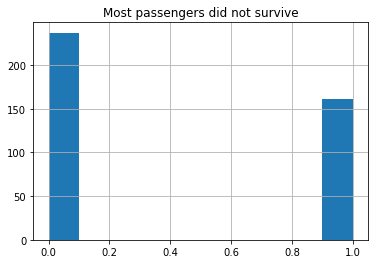

In [11]:
plt.title("Most passengers did not survive")
train.survived.hist()
plt.show()

In [12]:
# We can call .mean() since 0 and 1 are numeric
print("Percent survived from train")
round(train.survived.mean(), 3)

Percent survived from train


0.405

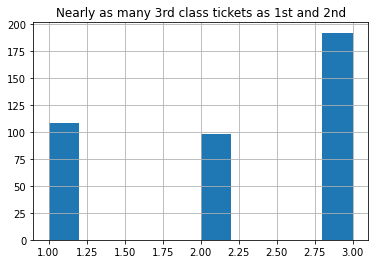

In [13]:
plt.title("Nearly as many 3rd class tickets as 1st and 2nd")
train.pclass.hist()
plt.show()

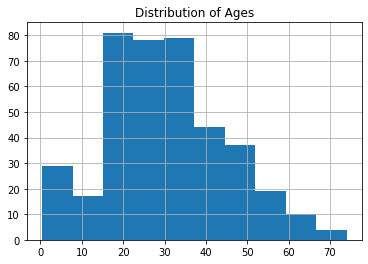

In [14]:
plt.title("Distribution of Ages")
train.age.hist()
plt.show()

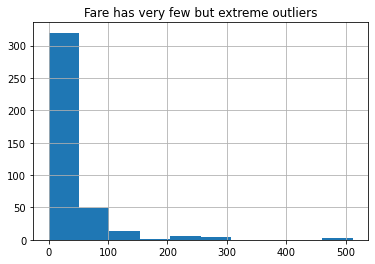

In [15]:
plt.title("Fare has very few but extreme outliers")
train.fare.hist()
plt.show()

**Takeaways & Actions**

- ~60% perished and ~40% survived. Predicting "not survived" will be our baseline prediction to test the usefulness of features on later when we get to modeling. (With classification, a good baseline is the mode of the target)

- Age seems close enough to a normal distribution

- Fare has some extreme outliers and might still not be normally distributed after removing them. If that's the case, then we would run a Mann-Whitney test instead of a t-test. Use the p-value in the same manner.

- Survived can be treated as either a categorical variable or a number. We can view survived via color on a chart, as categories on the x-axis on a bar chart, or as a proportion between 0 and 1 on the y-axis when viewing another categorical variable to compare "survival rate". 

- We can compare proportions of those who survived and those who didn't with another categorical variable. For example, we can test is female passengers were more or less likely to survive than male passengers using a chi-square test. 

- We can compare the mean of continuous variables between those who survived to those who did not survive using a test such as a t-test or Mann-Whitney test (the non-parametric version of the t-test). Such as, is there a difference in the average fare paid for those who survived vs. those who did not survive? 

- *What else?*

## Interactions of 2 Variables

For bivariate exploration, we should analyze each feature with respect to the target variable and document takewaways. 

A scatterplot will help us visualize numeric to numeric columns.

A catplot, barplot, or boxplot will help us visualize categorical variables with numeric variables. A nice thing about a `.barplot` is that by setting the binary target to the `y` axis, we see proportions.

Always write down what questions you have before you explore.

Always document your findings and takeaways, even if the takeaway is "There's nothing here between x and y"

Some findings from bi-variate exploration may need more detailed investigation with an additional variable...

In [16]:
train.head(2)

,survived,pclass,age,sibsp,parch,fare,embarked,alone,is_female,embark_Cherbourg,embark_Queenstown,embark_Southampton
450,0,2,36.0,1,2,27.75,S,0,0,0,0,1
543,1,2,32.0,1,0,26.00,S,0,0,0,0,1


**Questions to answer**

1. `pclass` to `survived`. What's the relationship between survival and class of ticket?

2. `alone` to `survived`. Is traveling with people more helpful for surviving?

3. `gender` to `survived`. What's the relationship between survival and gender?

4. `fare` to `survived`. What's the relationship between fare and survival?


What further combinations of features could you analyze? What about binning age into young, middle, and older? Are there any features that would make sense to create? 

_____________________

**1. What's the relationship between survival and class of ticket?**

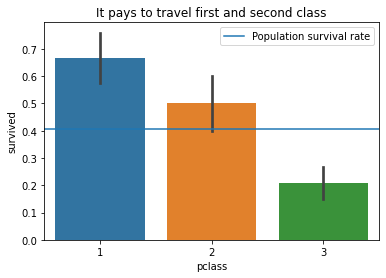

In [17]:
plt.title("It pays to travel first and second class")
sns.barplot(x="pclass", y="survived", data=train)
population_survival_rate = train.survived.mean()
plt.axhline(population_survival_rate, label="Population survival rate")
plt.legend()
plt.show()

The above visual is quite clear, but if it was less clear or we want more certainty, we'll run a hypothesis test. 

In [18]:

# Let's run a chi squared to compare proportions, to have more confidence
alpha = 0.05
null_hypothesis = "survival and class of ticket are independent"
alternative_hypothesis = "there is a relationship between class of ticket and survival"

# Setup a crosstab of observed survival to pclass
observed = pd.crosstab(train.survived, train.pclass)

chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("Reject the null hypothesis that", null_hypothesis)
    print("Sufficient evidence to move forward understanding that", alternative_hypothesis)
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null")
p

Reject the null hypothesis that survival and class of ticket are independent
Sufficient evidence to move forward understanding that there is a relationship between class of ticket and survival


6.956716773744683e-15

**2. Is traveling with people more helpful for surviving?**

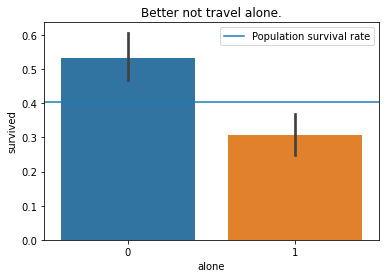

In [19]:
plt.title("Better not travel alone.")
sns.barplot(x="alone", y="survived", data=train)
population_survival_rate = train.survived.mean()
plt.axhline(population_survival_rate, label="Population survival rate")
plt.legend()
plt.show()

In [20]:
# If the visual was unclear or we need more confirmation, run a hypothesis test
# Let's run a chi squared to compare proportions
alpha = 0.05
null_hypothesis = "survival and traveling alone are independent"
alternative_hypothesis = "there is a relationship between survival and traveling alone"

# Setup a crosstab of observed survival to pclass
observed = pd.crosstab(train.survived, train.alone)

chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("Reject the null hypothesis that", null_hypothesis)
    print("Sufficient evidence to move forward understanding that", alternative_hypothesis)
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null")

Reject the null hypothesis that survival and traveling alone are independent
Sufficient evidence to move forward understanding that there is a relationship between survival and traveling alone


**3. What's the relationship between survival and gender?**

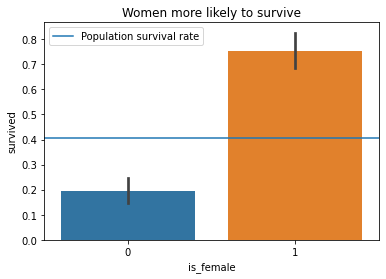

In [21]:
plt.title("Women more likely to survive")
sns.barplot(x="is_female", y="survived", data=train)
population_survival_rate = train.survived.mean()
plt.axhline(population_survival_rate, label="Population survival rate")
plt.legend()
plt.show()

In [22]:
# Let's run a chi squared to compare proportions, to have more confidence
alpha = 0.05

null_hypothesis = "survival and gender are independent"
alternative_hypothesis = "there is a relationship between survival and gender"

# Setup a crosstab of observed survival to pclass
observed = pd.crosstab(train.survived, train.is_female)

chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("Reject the null hypothesis that", null_hypothesis)
    print("Sufficient evidence to move forward understanding that", alternative_hypothesis)
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null")

Reject the null hypothesis that survival and gender are independent
Sufficient evidence to move forward understanding that there is a relationship between survival and gender


**4. What's the relationship between fare and survival?**

Comparing Numeric vs. a Categorical Example

If the visual is not completely clear, the need for a hypothesis test increases. 

1. First, set your confidence level and your alpha (Confidence level of 95% and alpha of 0.05 are good)
2. Select the appropriate test for your 2 variables:
    - If numeric to numeric, run a correlation test
    - Compare proportions with $\chi^2$
    - Compare means with t-test or Mann-Whitney u-test. 
3. Run tests, form conclusions, and document your results

(rinse and then repeat with other variables of interest)

1 tailed Mann-Whitney test. For more on Mann-Whitney, see the [Wikipedia article](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test)

Write down your hypothesis setup

- $H_{0}$: Survived passenger fares cost less than or equal to non-surviving passenger fare

- $H_{a}$: Surviving passenger fares cost more than non-surviving passenger fares

In [23]:
# Subset the data into survived and not-surviving status
not_survived = train[train.survived == 0]
survived = train[train.survived == 1]

In [24]:
# check variances of the two groups
not_survived.fare.var(), survived.fare.var()

(846.4473286218973, 7299.474755819128)

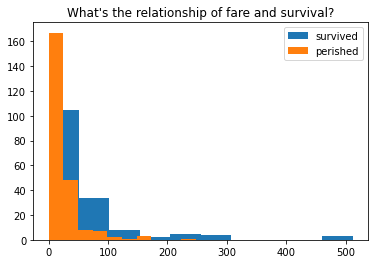

In [25]:
plt.title("What's the relationship of fare and survival?")
plt.hist(survived.fare, label="survived")
plt.hist(not_survived.fare, label="perished")
plt.legend()
plt.show()

In [26]:
from scipy import stats

null_hypothesis = "fares paid by survived passengers are less than or equal to fares paid by non-surviving passengers"
alternative_hypothesis = "fares paid by surviving passengers are higher than non-surviving passengers"

# Use Mann Whitney u-test when t-test assumptions do not hold.
# The distributions are not normal and the variances are not equal, so we'll do mann-whitney
t, p = stats.mannwhitneyu(survived.fare, not_survived.fare, alternative="greater")

In [27]:
if p < alpha:
    print("We find evidence to reject the null hypothesis that", null_hypothesis)
    print("We find evidence evidence to move forward with the understaind that", alternative_hypothesis)
else:
    print("We fail to reject the null hypothesis")
    print("There is no evidence that", null_hypothesis)

We find evidence to reject the null hypothesis that fares paid by survived passengers are less than or equal to fares paid by non-surviving passengers
We find evidence evidence to move forward with the understaind that fares paid by surviving passengers are higher than non-surviving passengers


In [28]:
p

4.665118844596931e-14

**Takeaways**

- It pays to travel first and second class
- Better to travel with family/company"
- Women much more likely to survive
- Survivors paid higher fares. This tracks with class of ticket.


**Important Questions** 

- What else can you determine by looking at `sibsp`, `parch`, `fare`, or `age` compared to our target `survived`
- If the visuals are not _crystal clear_ in indicating a relationship, then we should conduct hypothesis testing with the approviate variables along with the target.
- For a second draft: 
    - Any other variables we can combine together?
    - Would it make sense to create a variable like `is_child` which would be a boolean?
    - Would it make sense to investigate each independent variable with each-other and not only the target?
- What else do you notice?
- And what else can we learn if we look at the interaction of more than two variables at a time?

## Interaction of 3+ Variables

During multivariate analysis, we often add another dimension to our data, such as the target variable as color.

We also ask additional, more specific and targeted questions of the data, such as how subgroups compare to each-other and to the overall population.
We then answer these questions using visualizations and/or hypothesis testing.

Some options for multivariate visuals:
- If you have multiple numeric columns, generating a [pairplot](https://seaborn.pydata.org/generated/seaborn.pairplot.html) with the target variable set to the `hue` argument might help. It may also be too noisy.
- A [relplot](https://seaborn.pydata.org/generated/seaborn.relplot.html) of a numeric x, a numeric y, and a `hue` or `col` argument using a category z. If you discover a good set of numeric columns in the `pairplot`, then it would be valuable to create a visual for that pairing along with the target.
- We can also use `hue` or `col` along with [seaborn catplot](https://seaborn.pydata.org/generated/seaborn.catplot.html)
- We can make subgroups based on multiple categorical features and compare to other groups or the population

Multivariate statistical tests exist, but are outside the scope of this course. 

We can, however, create subgroups based on multiple categorical features and conduct hypothesis tests.

**In each class of ticket, survivors trend younger**

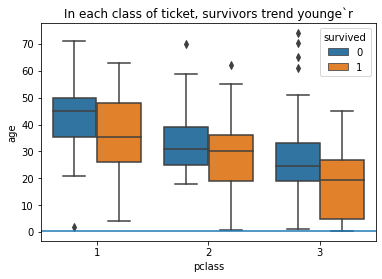

In [29]:
# At each class ticket, women have better survival rates
plt.title("In each class of ticket, survivors trend younger")
sns.boxplot(x="pclass", y="age", data=train, hue="survived")
population_survival_rate = train.survived.mean()
plt.axhline(population_survival_rate)
plt.show()

**Note**
A scatterplot of 2 numeric columns by one or two categorical columns might be very useful for numeric targets on your y axis

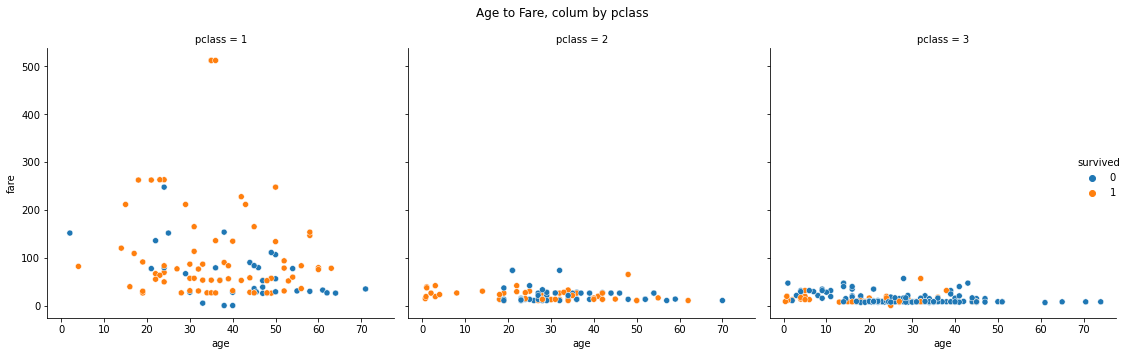

In [30]:
# No discernable relationship between age and fare, but the pclass relates to survival
rel = sns.relplot(x='age', y='fare', data=train, col="pclass", hue="survived")
rel.fig.suptitle('Age to Fare, colum by pclass') # One way to title a relplot
plt.tight_layout()

**Women more likely to survive at all ticket classes**

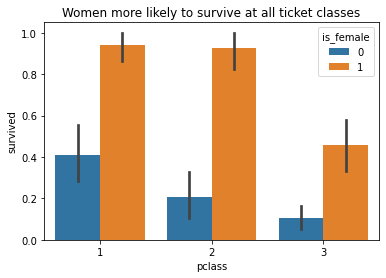

In [31]:
plt.title("Women more likely to survive at all ticket classes")
sns.barplot(x="pclass", y="survived", hue="is_female", data=train)
population_survival_rate = train.survived.mean()
plt.show()

In [32]:
women_in_3rd_class = train[(train.pclass == 3) & (train.is_female == 1)]
men_in_3rd_class = train[(train.pclass == 3) & (train.is_female == 0)]

print(f"Overall survival rate:", round(train.survived.mean(), 2))
print(f"Overall female survival rate", round(train[train.is_female == 1].survived.mean(), 2))
print(f"Overall male survival rate", round(train[train.is_female == 0].survived.mean(), 2))
print(f"3rd class ticket survival rate", round(train[train.pclass == 3].survived.mean(), 2))
print(f"Survival rate for women in 3rd class:", round(women_in_3rd_class.survived.mean(), 2))
print(f"Survival rate for men in 3rd class:", round(men_in_3rd_class.survived.mean(), 2))

Overall survival rate: 0.4
Overall female survival rate 0.75
Overall male survival rate 0.2
3rd class ticket survival rate 0.21
Survival rate for women in 3rd class: 0.46
Survival rate for men in 3rd class: 0.1


**Traveling alone, at any class ticket is riskier**

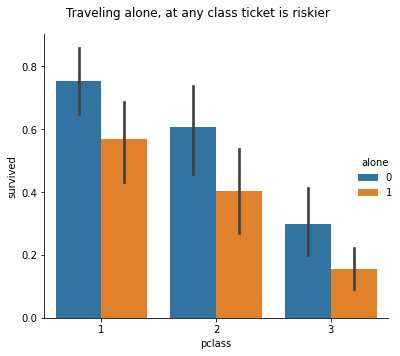

In [33]:
cat = sns.catplot(data=train, x="pclass", y="survived", hue="alone", kind="bar")
cat.fig.suptitle("Traveling alone, at any class ticket is riskier")
plt.tight_layout()

**Takeaways**
1. Women more likely to survive at all ticket classes
2. In each class of ticket, survivors trend younger
3. First class alone has better survival than 3rd class traveling with family
4. Fare and age don't seem to correlate, but fare and class of ticket appear related.
5. For both men and women passengers, survival and pclass are dependent

*What do you learn from these? What are some actions you wish to take?*

In [34]:
# Gender subset setup
male_subset = train[train.is_female == 0]
female_subset = train[train.is_female == 1]

In [35]:
null_hypothesis = "survival and pclass are independent for female passengers"
alternative_hypothesis = "survival and pclass are dependent for female passengers"

alpha = 0.05
observed = pd.crosstab(female_subset.survived, female_subset.pclass)
chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("We reject the null hypothesis that", null_hypothesis)
    print("Evidence suggests that", alternative_hypothesis)
else:
    print("We fail to reject the null hypothesis")
    print("We find insufficient evidence to support the claim that", alternative_hypothesis)

We reject the null hypothesis that survival and pclass are independent for female passengers
Evidence suggests that survival and pclass are dependent for female passengers


In [36]:
null_hypothesis = "survival and pclass are independent for male passengers"
alternative_hypothesis = "survival and pclass are dependent for male passengers"

alpha = 0.05
observed = pd.crosstab(male_subset.survived, male_subset.pclass)
chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("We reject the null hypothesis that", null_hypothesis)
    print("Evidence suggests that", alternative_hypothesis)
else:
    print("We fail to reject the null hypothesis")
    print("We find insufficient evidence to support the claim that", alternative_hypothesis)

We reject the null hypothesis that survival and pclass are independent for male passengers
Evidence suggests that survival and pclass are dependent for male passengers


**Get Creative**

Ask additional, more specific and targeted questions of the data, such as how subgroups compare to each-other and to the overall population. We then answer these questions using visualizations and/or hypothesis testing.

1. Is there a relationship between survival and parch for women travelers?
2. Is there a relationship between survival and parch for male travelers? 
3. Is there a relationship between survival and sibsp for women travelers? 
4. Is there a relationship between survival and sibsp for male travelers?

What other subgroups can you create and visualize?

What variables have you not worked with yet?


What other subgroups can you create and test?

## Conclusion

Here we pull all of our takeaways and actions together into one place we can reference as we move forward. 

- Overall, 60% did NOT survive. This will be my baseline prediction to test the usefulness of features on later when we get to modeling. 

- Younger people appear more likely to survive. A new feature of `is_child` might be helpful, or maybe binning age into 3 groups of "young", "middle", and "older" would be more helpful than age as a numeric column, alone.

- Take all of your takeaways and document them in one place.

- If we have time, maybe on a second iteration, we can dive deep into more variable pairings.


**Work fast to an MVP understanding of your data**

- Focus on features that give you the biggest bang for your buck. 

- If there's 30% of a population that's responsible for 99% of the sales, starting with breaking down that 30% population into different groups 


**When you have time for a second iteration**

- Revisit some of the things you may have skipped earlier in order to get to an MVP.

- For example, there were ~20% of rows with missing age. If you have time, check these out. Is there a set of the population that is similar such that we can impute an expected age value?

- Explore creating your own features

    - Turning numeric columns like `age` into a category with `is_child`, for example with a boolean.
    - Where does it make logical sense to combine columns  

## Exercises

### Part 1

Continue in your `classification_exercises.ipynb` notebook. As always, add, commit, and push your changes.

**Section 1 - iris_db:** Using iris data from our mySQL server and the methods used in the lesson above: 

1. Acquire, prepare & split your data. 

1. Univariate Stats

    - For each measurement type (quantitative variable): create a histogram, boxplot, & compute descriptive statistics (using .describe()). 

    - For each species (categorical variable): create a frequency table and a bar plot of those frequencies. 

    - Document takeaways & any actions. 


2. Bivariate Stats

    - Visualize each measurement type (y-axis) with the species variable (x-axis) using barplots, adding a horizontal line showing the overall mean of the metric (y-axis). 

    - For each measurement type, compute the descriptive statistics for each species. 

    - For virginica & versicolor: Compare the mean petal_width using the Mann-Whitney test (scipy.stats.mannwhitneyu) to see if there is a significant difference between the two groups. Do the same for the other measurement types. 

    - Document takeaways & any actions. 


3. Multivariate Stats

    - Visualize the interaction of each measurement type with the others using a pairplot (or scatter matrix or something similar) and add color to represent species. 
    
    - Visualize two numeric variables by means of the species. Hint: `sns.relplot` with `hue` or `col`

    - Create a swarmplot using a melted dataframe of all your numeric variables. The x-axis should be the variable name, the y-axis the measure. Add another dimension using color to represent species. Document takeaways from this visualization.

    - Ask a specific question of the data, such as: is the sepal area signficantly different in virginica compared to setosa? Answer the question through both a plot and using a mann-whitney or t-test. If you use a t-test, be sure assumptions are met (independence, normality, equal variance). 

    - Document takeaways and any actions. 



### Part II

Explore your `titanic` dataset more completely.

- Determine drivers of the target variable
- Determine if certain columns should be dropped
- Determine if it would be valuable to bin some numeric columns
- Determine if it would be valuable to combine multiple columns into one.

Does it make sense to combine any features?

Do you find any surprises?

Document any and all findings and takeaways in your notebook using markdown.

### Part III

- Explore your `telco` data to discover drivers of churn
- Determine if certain columns should be dropped
- Determine if it would be valuable to bin some numeric columns
- Determine if it would be valuable to combine multiple columns into one.

What are your drivers of churn?

Does it make sense to combine any features?

Do you find any surprises?

Document any and all findings and takeaways in your notebook using markdown.